In [47]:
import numpy as np
import pandas as pd
from pylab import mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import yfinance as yf
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import svd

plt.style.use('seaborn-v0_8-paper')
mpl.rcParams['font.serif'] = 'Times'
%matplotlib inline

In [48]:
data = pd.read_csv('btc_2024.csv', sep=',', index_col='timestamp')

data

,open,high,low,close,volume
timestamp,,,,,
2024-01-01 00:00:00,42283.58,42298.62,42261.02,42298.61,35.92724
2024-01-01 00:01:00,42298.62,42320.00,42298.61,42320.00,21.16779
2024-01-01 00:02:00,42319.99,42331.54,42319.99,42325.50,21.60391
2024-01-01 00:03:00,42325.50,42368.00,42325.49,42367.99,30.50730
2024-01-01 00:04:00,42368.00,42397.23,42367.99,42397.23,46.05107
...,...,...,...,...,...
2024-12-31 23:55:00,93646.97,93667.52,93646.96,93667.52,4.31339
2024-12-31 23:56:00,93667.51,93676.98,93636.37,93636.37,2.87066
2024-12-31 23:57:00,93636.38,93643.24,93616.04,93616.04,2.19230


In [49]:
figs=(24,9)

Here, we'll start by modelling our chaotic equation systems and observe their caracteristics, like their strange attractor, Fourier spectrum, Fractal dimension, or Lyapunov exponent

In [50]:
def lorenz_map(length, sigma=10, rho=28, beta=8/3, dt=0.01):
    x = np.zeros(length)
    y = np.zeros(length)
    z = np.zeros(length)
    
    # Conditions initiales
    x[0], y[0], z[0] = 1.0, 1.0, 1.0
    
    for t in range(1, length):
        dx = sigma * (y[t-1] - x[t-1])
        dy = rho * x[t-1] - y[t-1] - x[t-1] * z[t-1]
        dz = x[t-1] * y[t-1] - beta * z[t-1]
        
        x[t] = x[t-1] + dx * dt
        y[t] = y[t-1] + dy * dt
        z[t] = z[t-1] + dz * dt
    
    return x, y, z

In [51]:
df_lorenz = pd.DataFrame()

df_lorenz['x'] = lorenz_map(len(data))[0]
df_lorenz['y'] = lorenz_map(len(data))[1]
df_lorenz['z'] = lorenz_map(len(data))[2]

df_lorenz.set_index(data.index)

,x,y,z
timestamp,,,
2024-01-01 00:00:00,1.000000,1.000000,1.000000
2024-01-01 00:01:00,1.000000,1.260000,0.983333
2024-01-01 00:02:00,1.026000,1.517567,0.969711
2024-01-01 00:03:00,1.075157,1.779722,0.959422
2024-01-01 00:04:00,1.145613,2.052653,0.952973
...,...,...,...
2024-12-31 23:55:00,9.438658,17.415631,13.247196
2024-12-31 23:56:00,10.236356,18.633942,14.537739
2024-12-31 23:57:00,11.076114,19.825647,16.057503


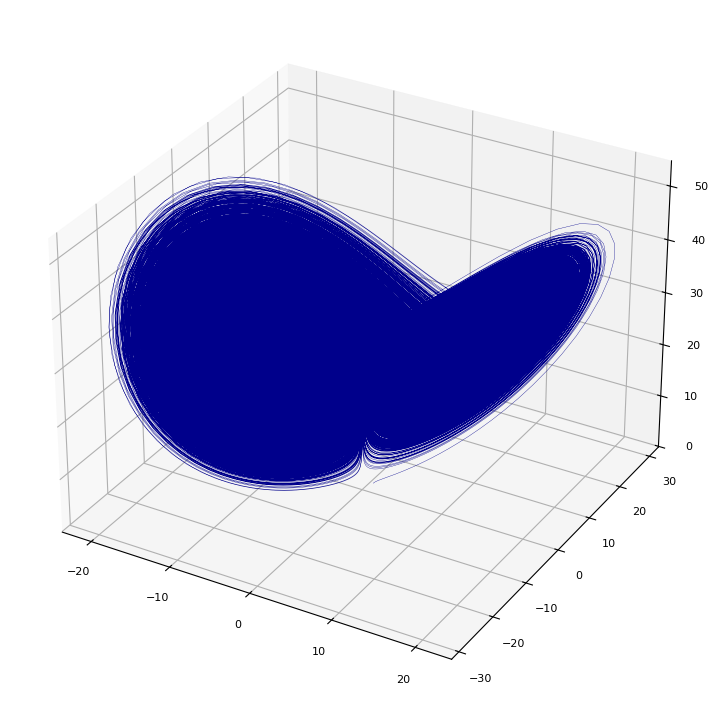

In [52]:
fig = plt.figure(figsize=figs)
ax = fig.add_subplot(111, projection='3d')
ax.plot(df_lorenz['x'], df_lorenz['y'], df_lorenz['z'], lw=0.25, color='darkblue')
plt.show()

In [53]:
def lorenz_stenflo_map(length, a=1, b=0.7, c=26, r=1.5, dt=0.01):
    x = np.zeros(length)
    y = np.zeros(length)
    z = np.zeros(length)
    w = np.zeros(length)

    # Conditions initiales
    x[0], y[0], z[0] = 1.0, 1.0, 1.0
    
    for t in range(1, length):
        dx = a * (y[t-1] - x[t-1]) + r * w[t-1]
        dy = c * x[t-1] - y[t-1] - x[t-1] * z[t-1]
        dz = x[t-1] * y[t-1] - b * z[t-1]
        dw = -x[t-1] - a*w[t-1]
        
        x[t] = x[t-1] + dx * dt
        y[t] = y[t-1] + dy * dt
        z[t] = z[t-1] + dz * dt
        w[t] = w[t-1] + dw * dt
    
    return x, y, z, w

In [54]:
df_lorenz_stenflo = pd.DataFrame()

df_lorenz_stenflo['x'] = lorenz_stenflo_map(len(data))[0]
df_lorenz_stenflo['y'] = lorenz_stenflo_map(len(data))[1]
df_lorenz_stenflo['z'] = lorenz_stenflo_map(len(data))[2]
df_lorenz_stenflo['w'] = lorenz_stenflo_map(len(data))[3]

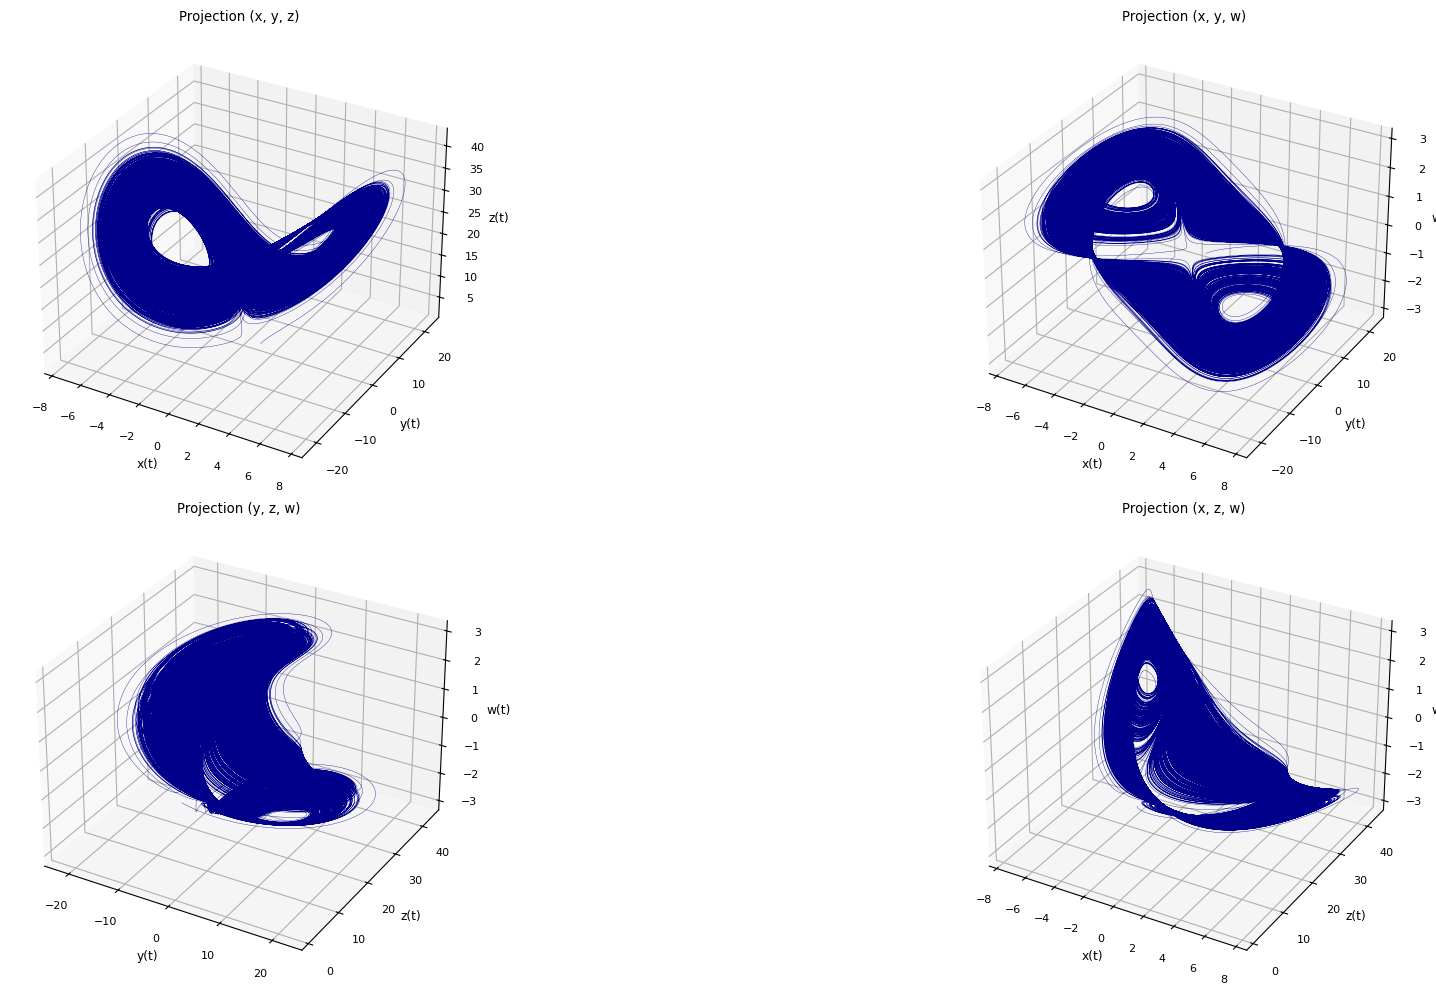

In [55]:
# Créer une figure avec 4 sous-graphiques 3D
fig = plt.figure(figsize=(24,10))

# Sous-graphique 1 : Projection (x, y, z)
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot(df_lorenz_stenflo['x'], df_lorenz_stenflo['y'], df_lorenz_stenflo['z'], lw=0.25, color='darkblue')
ax1.set_title("Projection (x, y, z)")
ax1.set_xlabel('x(t)')
ax1.set_ylabel('y(t)')
ax1.set_zlabel('z(t)')

# Sous-graphique 2 : Projection (x, y, w)
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot(df_lorenz_stenflo['x'], df_lorenz_stenflo['y'], df_lorenz_stenflo['w'], lw=0.25, color='darkblue')
ax2.set_title("Projection (x, y, w)")
ax2.set_xlabel('x(t)')
ax2.set_ylabel('y(t)')
ax2.set_zlabel('w(t)')

# Sous-graphique 3 : Projection (y, z, w)
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot(df_lorenz_stenflo['y'], df_lorenz_stenflo['z'], df_lorenz_stenflo['w'], lw=0.25, color='darkblue')
ax3.set_title("Projection (y, z, w)")
ax3.set_xlabel('y(t)')
ax3.set_ylabel('z(t)')
ax3.set_zlabel('w(t)')

# Sous-graphique 4 : Projection (x, z, w)
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot(df_lorenz_stenflo['x'], df_lorenz_stenflo['z'], df_lorenz_stenflo['w'], lw=0.25, color='darkblue')
ax4.set_title("Projection (x, z, w)")
ax4.set_xlabel('x(t)')
ax4.set_ylabel('z(t)')
ax4.set_zlabel('w(t)')

# Ajuster la mise en page
plt.tight_layout()
plt.show()

In [56]:
def rikitake(length, mu = 0.7, epsilon = 0.2, dt = 0.01):
    x = np.zeros(length)
    y = np.zeros(length)
    z = np.zeros(length)

    x[0], y[0], z[0] = 1, 1, 1
    
    for t in range (1, length):
        dx = -mu*x[t-1] + y[t-1]*z[t-1]
        dy = -mu*y[t-1] + x[t-1]*(z[t-1] - epsilon)
        dz = 1 - x[t-1]*y[t-1]

        x[t] = x[t-1] + dx*dt
        y[t] = y[t-1] + dy*dt
        z[t] = z[t-1] + dz*dt

    return x, y, z

In [57]:
df_rikitake = pd.DataFrame()

df_rikitake['x'] = rikitake(len(data))[0]
df_rikitake['y'] = rikitake(len(data))[1]
df_rikitake['z'] = rikitake(len(data))[2]

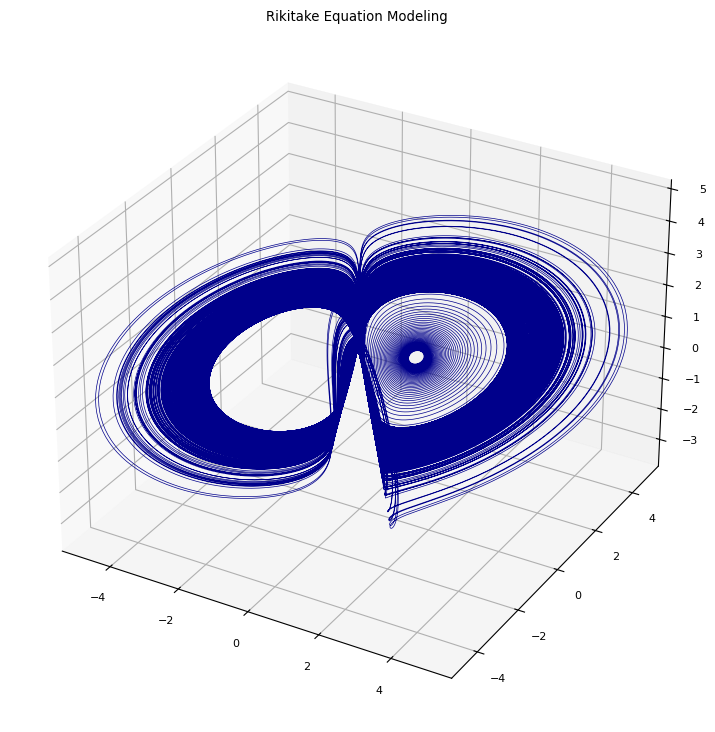

In [58]:
fig = plt.figure(figsize=figs)
ax = fig.add_subplot(111, projection='3d')
ax.plot(df_rikitake['x'], df_rikitake['y'], df_rikitake['z'], lw=0.5, color='darkblue')
plt.title('Rikitake Equation Modeling')
plt.show()